In [174]:
import os
import math
import random
import logging
from tqdm import tqdm
from operator import attrgetter
from operator import itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from collections.abc import Mapping

import torch
from torch import nn, tensor
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from datasets import load_dataset, load_dataset_builder

import fastcore.all as fc
from fastcore.test import test_close
from fastprogress import progress_bar, master_bar

In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [3]:
logging.disable(logging.WARNING)

# Learner

In [4]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
bs = 1024
tds = dsd.with_transform(transformi)

In [6]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs, **kwargs))

class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:1]
    
    @classmethod
    def from_dd(cls, dd):
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f))

In [7]:
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f))

In [8]:
itemgetter?

Init signature: itemgetter(self, /, *args, **kwargs)
Docstring:     
itemgetter(item, ...) --> itemgetter object

Return a callable object that fetches the given item(s) from its operand.
After f = itemgetter(2), the call f(r) returns r[2].
After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
File:           ~/mambaforge/lib/python3.9/operator.py
Type:           type
Subclasses:     


In [9]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [10]:
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [11]:
def collate_device(b): return to_device(default_collate(b))

In [34]:
class Learner: 
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
        
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl):
            self.one_batch()
        n = sum(self.ns)
        print(f'Epoch: {self.epoch+1} | Loss: {sum(self.losses).item()/n} | Acc: {sum(self.accs).item()/n}')
 
    def fit(self, n_epochs):
        self.ns, self.losses, self.accs = [], [], []
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        
        self.n_epochs = n_epochs
        for self.epoch in range(self.n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
    

In [35]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [36]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

Epoch: 1 | Loss: 1.1550600260416666 | Acc: 0.61965
Epoch: 1 | Loss: 1.1036938616071428 | Acc: 0.6295714285714286


# Basic Callbacks Learner

In [42]:
# class CancelFitException(Exception): pass
# class CancelBatchException(Exception): pass
# class CancelEpochException(Exception): pass

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [43]:
class Callback(): order = 0

In [44]:
# def run_cbs(cbs, method_nm, learn=None):
#     for cb in sorted(cbs, key=attrgetter('order')):
#         method = getattr(cb, method_nm, None)
#         if method is not None: method(learn)

def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [45]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [46]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [78]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in tqdm(enumerate(self.dl), total=len(self.dl)):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [91]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(self.n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
        
    
    def callback(self, method_nm): return run_cbs(self.cbs, method_nm, self)

In [92]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [93]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])

In [94]:
learn.fit(2)

Completed 138 batches


In [95]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [96]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])

In [97]:
learn.fit(1)

# Metrics

In [115]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals, self.ns = [], []
    
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    ## this is for the loss
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()

    def calc(self, inps, targs): return inps

In [116]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps==targs).float().mean()

In [117]:
acc = Accuracy()
acc.add(tensor([0,1,2,0,1,2]), tensor([0,1,1,2,1,0]))
acc.add(tensor([1,1,2,0,1]), tensor([0,1,1,2,1]))

In [118]:
acc.value

tensor(0.45)

In [119]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

# Some Callbacks

In [120]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [122]:
metric = MulticlassAccuracy()

In [123]:
metric.update(tensor([0,2,1,3]), tensor([0,1,2,3]))

In [124]:
metric.compute()

tensor(0.50)

In [125]:
metric.reset()

In [126]:
metric.compute()

tensor(nan)

In [127]:
def to_cpu(x):
    if isinstance(x,Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x,list): return [to_cpu(o) for o in x]
    if isinstance(x,tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [128]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = 0
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)

    def before_fit(self, learn): learn.metrics = self
    
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [129]:
metrics_cb = MetricsCB(accuracy=MulticlassAccuracy(), mean=Mean())
metrics_cb.metrics

{'accuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy at 0x7f19646d0670>,
 'mean': <torcheval.metrics.aggregation.mean.Mean at 0x7f196497d940>}

In [130]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [131]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.600', 'loss': '1.200', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.707', 'loss': '0.774', 'epoch': 0, 'train': 'eval'}


# Flexible Learner

In [142]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [143]:
# master_bar??

In [144]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [145]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [148]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()
        
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl): self._one_batch()
    
    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)
        
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.625,1.162,0,train
0.703,0.809,0,eval


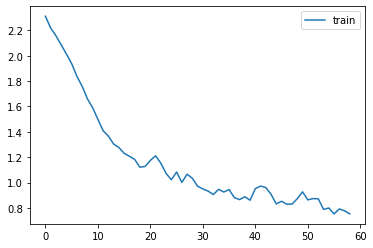

In [149]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [150]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [151]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.685,0.935,0,train
0.802,0.568,0,eval


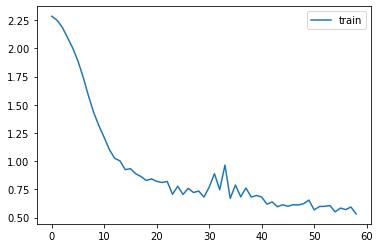

In [152]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

# LRFinderCB

In [156]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if loss > self.min * 3: 
            raise CancelFitException()
        for g in learn.opt.param_groups: 
            g['lr'] *= self.lr_mult

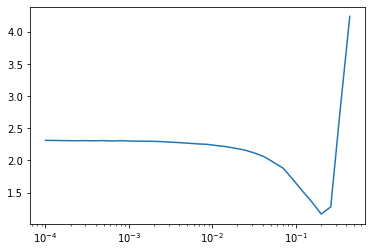

In [157]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [158]:
from torch.optim.lr_scheduler import ExponentialLR

In [159]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

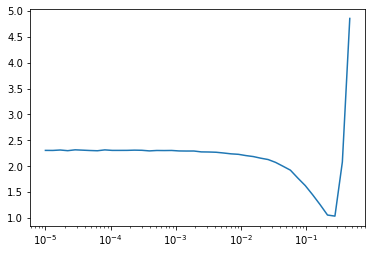

In [161]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [166]:
@fc.patch??

Signature: fc.patch(f=None, *, as_prop=False, cls_method=False)
Source:   
def patch(f=None, *, as_prop=False, cls_method=False):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    if f is None: return partial(patch, as_prop=as_prop, cls_method=cls_method)
    ann,glb,loc = get_annotations_ex(f)
    cls = union2tuple(eval_type(ann.pop('cls') if cls_method else next(iter(ann.values())), glb, loc))
    return patch_to(cls, as_prop=as_prop, cls_method=cls_method)(f)
File:      ~/mambaforge/lib/python3.9/site-packages/fastcore/basics.py
Type:      function


In [162]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

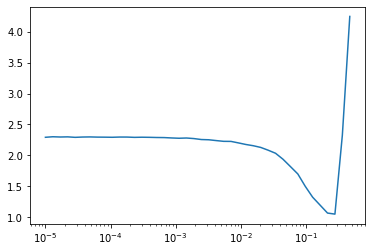

In [163]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

# Activations

In [167]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [168]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace 
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

In [184]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [185]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [186]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.156,2.298,0,train
0.295,2.044,0,eval


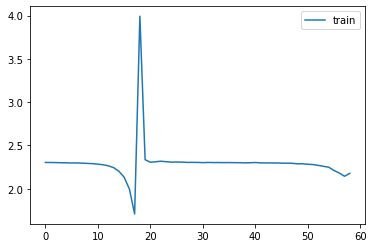

In [187]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

# Hooks

## Manual insertion

In [188]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.161,2.298,0,train
0.207,2.060,0,eval


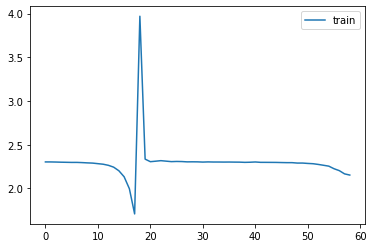

In [189]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

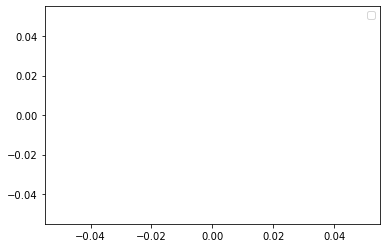

In [190]:
for l in model.act_means: plt.plot()
plt.legend(range(5))

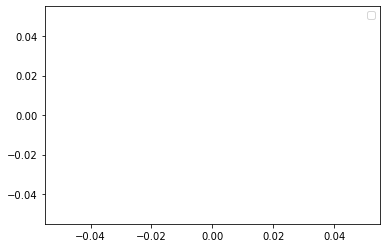

In [191]:
for l in model.act_stds: plt.plot()
plt.legend(range(5))

## Pytorch hooks

In [195]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [196]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [197]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.153,2.301,0,train
0.191,2.145,0,eval


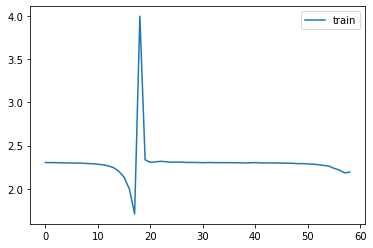

In [199]:
fit(model)

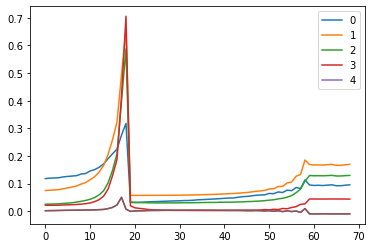

In [200]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

# Hook class

In [201]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [202]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [203]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [204]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.162,2.298,0,train
0.198,2.101,0,eval


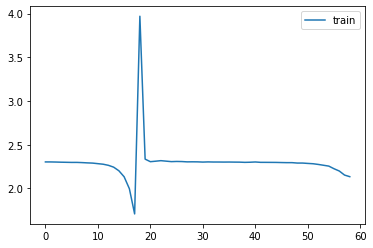

In [205]:
learn = fit(model)

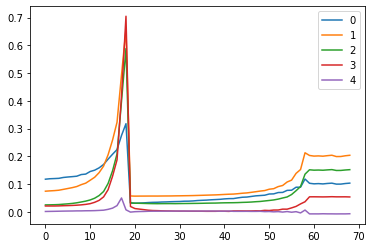

In [206]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

## A Hooks class

In [207]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    
    def __exit__(self, *args): print("all done!")
    def hello(self): print("hello.")

In [208]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [209]:
class DummyList(list):
    def __delitem__(self, i):
        print(f'Say bye to item {i}')
        super().__delitem__(i)

In [210]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [211]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [212]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [213]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.156,2.301,0,train
0.199,2.148,0,eval


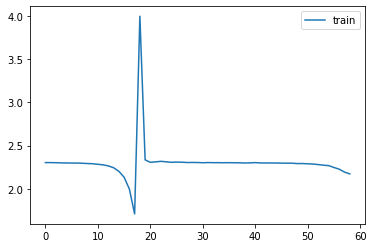

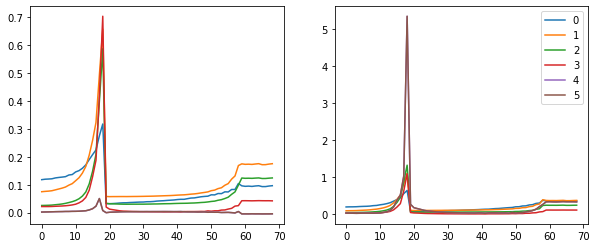

In [214]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

## HooksCallback

In [217]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [218]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.155,2.300,0,train
0.203,2.081,0,eval


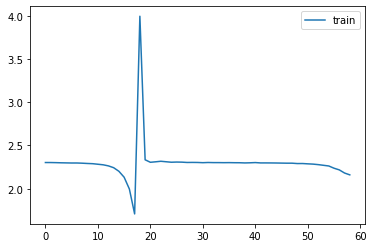

In [219]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

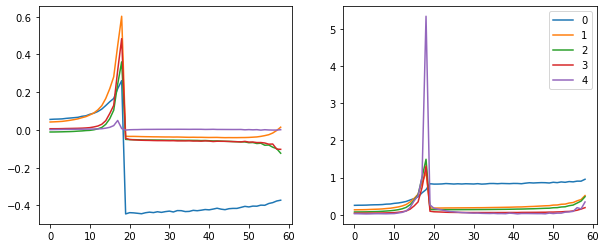

In [220]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [221]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.480,1.426,0,train
0.686,0.801,0,eval


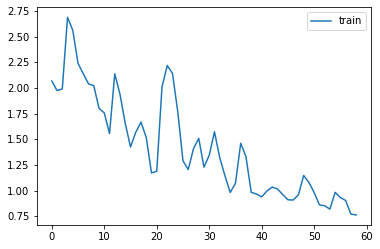

In [223]:
set_seed(1)
moel = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc])

In [231]:
# %% ../nbs/05_datasets.ipynb 37
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

# %% ../nbs/05_datasets.ipynb 41
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

# %% ../nbs/05_datasets.ipynb 45
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

# %% ../nbs/05_datasets.ipynb 47
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int, # Number of rows in grid
                ncols:int, # Number of columns in grid (auto-calculated if None)
                titles:list, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [235]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

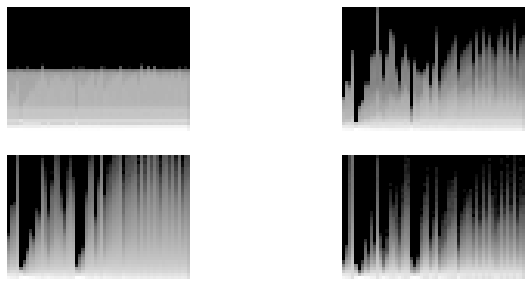

In [236]:
fig, axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [237]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

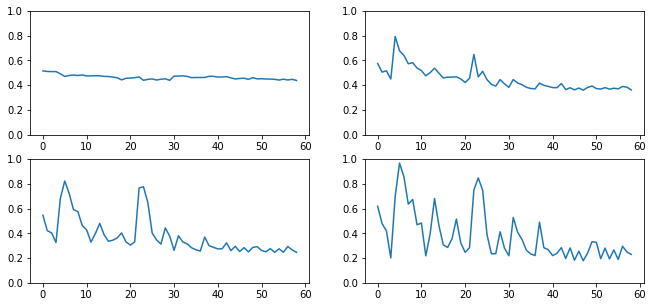

In [238]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

# ActivationStats

In [239]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [240]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.153,2.301,0,train
0.212,2.111,0,eval


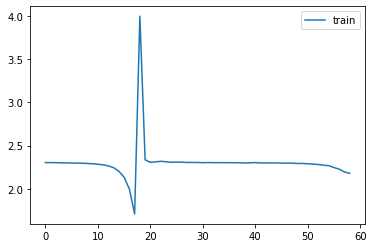

In [241]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

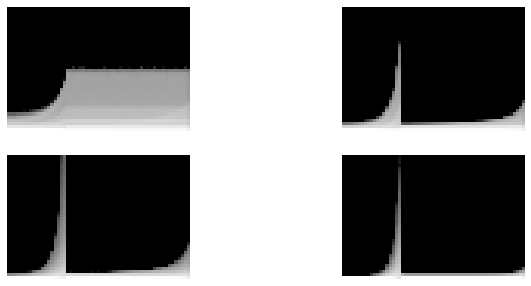

In [242]:
astats.color_dim()

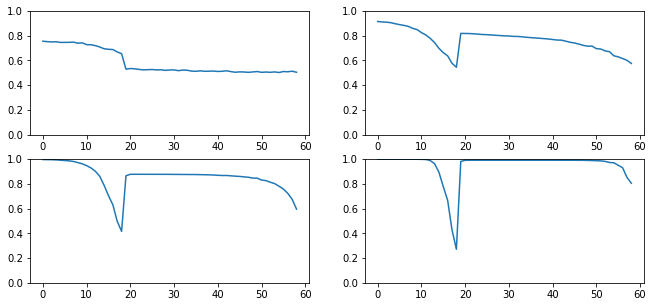

In [243]:
astats.dead_chart()

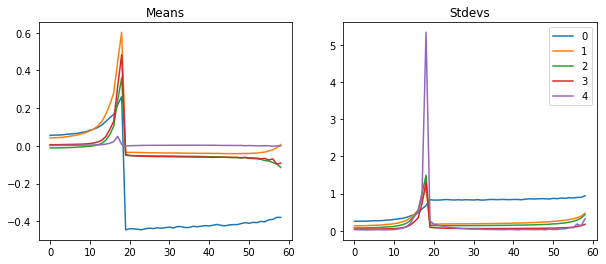

In [244]:
astats.plot_stats()